In [1]:
# Step 1: Import Necessary Libraries
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, sum, avg, count, desc, percentile_approx
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Step 2: Initialize Spark Session
spark = SparkSession.builder.appName("RetailSalesAnalysis").getOrCreate()

In [4]:
# Step 3: Load Dataset
df = spark.read.option("header", True).csv("retail_sales_dataset.csv")

In [5]:
# Step 4: Inspect Data
df.printSchema()
df.show(5)

root
 |-- Transaction ID: string (nullable = true)
 |-- Date: string (nullable = true)
 |-- Customer ID: string (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Age: string (nullable = true)
 |-- Product Category: string (nullable = true)
 |-- Quantity: string (nullable = true)
 |-- Price per Unit: string (nullable = true)
 |-- Total Amount: string (nullable = true)

+--------------+----------+-----------+------+---+----------------+--------+--------------+------------+
|Transaction ID|      Date|Customer ID|Gender|Age|Product Category|Quantity|Price per Unit|Total Amount|
+--------------+----------+-----------+------+---+----------------+--------+--------------+------------+
|             1|2023-11-24|    CUST001|  Male| 34|          Beauty|       3|            50|         150|
|             2|2023-02-27|    CUST002|Female| 26|        Clothing|       2|           500|        1000|
|             3|2023-01-13|    CUST003|  Male| 50|     Electronics|       1|            30|  

In [6]:
# Step 5: Clean Data
df = df.dropna().dropDuplicates()

# Convert numerical columns to proper types
df = df.withColumn("Age", col("Age").cast("int")) \
       .withColumn("Quantity", col("Quantity").cast("int")) \
       .withColumn("Price per Unit", col("Price per Unit").cast("double")) \
       .withColumn("Total Amount", col("Total Amount").cast("double"))

In [7]:
# Step 6: Top-Selling Products
top_products = df.groupBy("Product Category").agg(
    sum("Total Amount").alias("Total Sales"),
    sum("Quantity").alias("Total Quantity Sold")
).orderBy(desc("Total Sales"))

In [9]:
# Step 7: Customer Segmentation

from pyspark.sql.functions import when
# Categorizing customers based on spending behavior
customer_segments = df.groupBy("Customer ID", "Age").agg(sum("Total Amount").alias("Total Spent"))

# Define spending thresholds using percentiles
high_value_threshold = customer_segments.approxQuantile("Total Spent", [0.75], 0.01)[0]  # 75th percentile
mid_value_threshold = customer_segments.approxQuantile("Total Spent", [0.50], 0.01)[0]  # 50th percentile

customer_segments = customer_segments.withColumn(
    "Segment",
    when(col("Total Spent") >= high_value_threshold, "High Value")
    .when(col("Total Spent") >= mid_value_threshold, "Mid Value")
    .otherwise("Low Value")
)


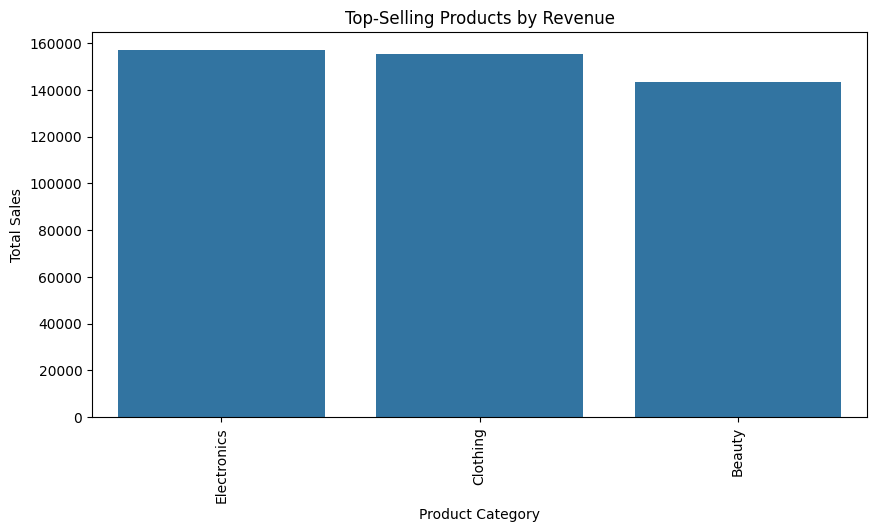

In [10]:
# Step 8: Visualization - Top Selling Products
pandas_products = top_products.toPandas()
plt.figure(figsize=(10,5))
sns.barplot(x="Product Category", y="Total Sales", data=pandas_products)
plt.xticks(rotation=90)
plt.title("Top-Selling Products by Revenue")
plt.xlabel("Product Category")
plt.ylabel("Total Sales")
plt.show()

In [ ]:
# Step 9: Save Processed Data
top_products.write.csv("output/top_products.csv", header=True)
customer_segments.write.csv("output/customer_segments.csv", header=True)

In [12]:
# Step 10: Optimization
df.cache()
spark.conf.set("spark.sql.shuffle.partitions", 50)

In [13]:
# Stop Spark Session
spark.stop()